In [1]:

# Plot each clusters
myHighlightDimPlot = function(seuratObj, highlightBy, size=1, alpha=1, showAllPoints=FALSE, ...) {
    umapTb = as_tibble(seuratObj@reductions$umap@cell.embeddings)
    if (!identical(rownames(seuratObj@reductions$umap@cell.embeddings), rownames(seuratObj@meta.data)))
        stop("Error: cell names not identical!")
    umapTb = cbind(umapTb, seuratObj@meta.data)
    highlightByClass = sort(unique(umapTb[[highlightBy]]))
    gpList = lapply(highlightByClass, function(cl) {
        subUmapTb = subset(umapTb, umapTb[[highlightBy]] == cl)
        if (showAllPoints) {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void() 
        } else {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void()
        }
        return(gp)
    })
    gpAll = plot_grid(plotlist=gpList, labels=highlightByClass, ...)
    return(gpAll)
}

In [1]:

suppressMessages(library(tidyverse))
suppressMessages(library(parallel))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratData))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(LSD))
suppressMessages(library(readxl))
suppressMessages(library(ggrepel))
suppressMessages(library(randomForest))
suppressMessages(library(harmony))


In [2]:
libMetaTb = read_xlsx(paste0(
    "/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0821_renew_batch3_all", 
    "/屏状核-建库清单.xlsx"
))

In [4]:
table(libMetaTb$`物种及组织部位`)


Macaca fascicularis猕猴屏状核                    小鼠屏状核 
                           40                            52 
                   狨猴屏状核 
                           44 

In [ ]:

readDir='/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0821_renew_batch3_all/batch_normalize_renew_1031/renew_fil_data_nFeature300_MT5/'
seurat1=readRDS(paste0(readDir,'macaca_snrna_all_soupX_fil_batch1_0425_1031.rds'))
seurat1$batch='batch1'

seurat2=readRDS(paste0(readDir,'macaque_snrna_all_soupX_fil_batch2_0709_1031.rds'))
seurat2$batch='batch2'

seurat3=readRDS(paste0(readDir,'macaque_snrna_all_soupX_fil_batch3_0821_1031.rds'))
seurat3$batch='batch3'

libMetaTb = read_xlsx(paste0(
    "/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0821_renew_batch3_all", 
    "/屏状核-建库清单.xlsx"
))


libMetaTb=libMetaTb[,c('分析样本名称','oligo文库名称')]
colnames(libMetaTb)=c('sampleId','sampleID')
libMetaTb$libId=str_extract(libMetaTb$sampleID,'[0-9][0-9][0-9][0-9]-[0-9]*')
libMetaTb$sampleID=NULL
libMetaTb=libMetaTb[!(is.na(libMetaTb$libId)),]
head(libMetaTb)

seurat=seurat2
seurat@meta.data$libId=seurat@meta.data$libId

tmpMetaTb = as_tibble(seurat@meta.data[c("libId")])
tmpMetaTb$cellId = rownames(seurat@meta.data)
tmpMetaTb = left_join(tmpMetaTb, libMetaTb[c("sampleId", "libId")], by="libId")
tmpMetaTb = column_to_rownames(tmpMetaTb, var="cellId")
identical(rownames(tmpMetaTb), rownames(seurat@meta.data))
# str(tmpMetaTb)
seurat = AddMetaData(seurat, tmpMetaTb)
seurat$sampleId = factor(seurat$sampleId)
seurat$libId = factor(seurat$libId)

setdiff(libMetaTb$libId, unique(seurat$libId))
length(setdiff(libMetaTb$libId, unique(seurat$libId)))

seurat2=seurat

classFiltSeurat1=merge(seurat1,seurat2)
classFiltSeurat=merge(classFiltSeurat1,seurat3)
classFiltSeurat

classFiltSeurat = SCTransform(
classFiltSeurat, assay="RNA",
ncells=ncol(classFiltSeurat[["RNA"]]),
variable.features.n=5000,
return.only.var.genes = T,
vars.to.regress="percent.mt",
method="glmGamPoi"
)
classFiltSeurat = classFiltSeurat %>%
RunPCA(npcs=100, verbose = FALSE) %>%
FindNeighbors(dims = 1:50) %>%
FindClusters(verbose = FALSE) %>%
RunUMAP(dims = 1:50)
saveRDS(classFiltSeurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0821_renew_batch3_all/batch_normalize_renew_1031/mid_data/3batch_merge_batchharmony_pre.rds')

# Run harmony
DefaultAssay(classFiltSeurat) = "SCT"
options(repr.plot.width=6, repr.plot.height=2.5)
classFiltSeurat = RunHarmony(
classFiltSeurat, group.by.vars="batch", plot_convergence=T,
assay.use="SCT", reduction = "pca", dims.use=1:50
)
classFiltSeurat = classFiltSeurat %>%
FindNeighbors(reduction="harmony", dims = 1:50) %>%
FindClusters(verbose = FALSE) %>%
RunUMAP(reduction="harmony", dims = 1:50)
return(classFiltSeurat)

saveRDS(classFiltSeurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0821_renew_batch3_all/batch_normalize_renew_1031/mid_data/3batch_merge_batchharmony.rds')




In [3]:
seurat=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0821_renew_batch3_all/batch_normalize_renew_1031/mid_data/3batch_merge_batchharmony_pre.rds')



In [4]:

#添加donor信息

cla=seurat
libMetaTb = read_xlsx(paste0(
    "/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0821_renew_batch3_all",
    "/屏状核-建库清单.xlsx"
))


libMetaTb=libMetaTb[,c('样本名称','分析样本名称','oligo文库名称')]
colnames(libMetaTb)=c('sample','sampleId','sampleID')
libMetaTb$libId=str_extract(libMetaTb$sampleID,'[0-9][0-9][0-9][0-9]-[0-9]*')
libMetaTb$sampleID=NULL
libMetaTb=libMetaTb[!(is.na(libMetaTb$libId)),]
head(libMetaTb)
libMetaTb1=libMetaTb

libMetaTb = read_xlsx(paste0(
    "/home/liuyx/liuyuxuan/spa_seurat/cla",
    "/sample_lib_meta.xlsx"
))
libMetaTb=libMetaTb[,c('jobid','tissue','sampleID')]
colnames(libMetaTb)=c('sample','sampleId','sampleID')
libMetaTb$libId=str_extract(libMetaTb$sampleID,'[0-9][0-9][0-9][0-9]-[0-9]')
libMetaTb$sampleID=NULL
libMetaTb=libMetaTb[!(is.na(libMetaTb$libId)),]
head(libMetaTb)
libMetaTb2=libMetaTb

libMetaTb=rbind(libMetaTb1,libMetaTb2)
ref=cla@meta.data[,'libId',drop=F]
ref$cell=rownames(ref)
ref=left_join(ref,libMetaTb)
cla=AddMetaData(cla,ref$sample,col.name = 'donor')

table(cla$donor)

cla$donor1=gsub('MQC','MQ',cla$donor)
cla$donor2=str_extract(cla$donor1,'MQ[0-9][0-9][0-9]')
table(cla$donor2)

sample,sampleId,libId
<chr>,<chr>,<chr>
MS-cla-001,MS-cla-001,2191-1
MS-cla-001,MS-cla-001,2191-2
MS-cla-001,MS-cla-001,2191-3
MS-cla-001,MS-cla-001,2191-4
MS-cla-001,MS-cla-001,2191-5
MS-cla-001,MS-cla-001,2191-6


New names:
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`


sample,sampleId,libId
<chr>,<chr>,<chr>
MQC286R-cla,Cla-rostral,6103-1
MQC286R-cla,Cla-rostral,6103-2
MQC286R-cla,Cla-rostral,6103-3
MQC286R-cla,Cla-rostral,6103-4
MQC286R-cla,Cla-rostral,6103-5
MQC286R-cla,Cla-rostral,6103-6


Joining, by = "libId"



  MQ277-157   MQ277-221   MQ277-222   MQ277-276   MQ277-277  MQ279R-004 
      11128       11821       10558       30594       27858       12044 
 MQ279R-005  MQ279R-006  MQ279R-007  MQ279R-008  MQ439R-108 MQC286R-036 
      11501       14936       14665       11490       89031       15486 
MQC286R-157 MQC286R-cla 
      30113        6699 


MQ277 MQ279 MQ286 MQ439 
91959 64636 52298 89031 

In [5]:
seurat=cla

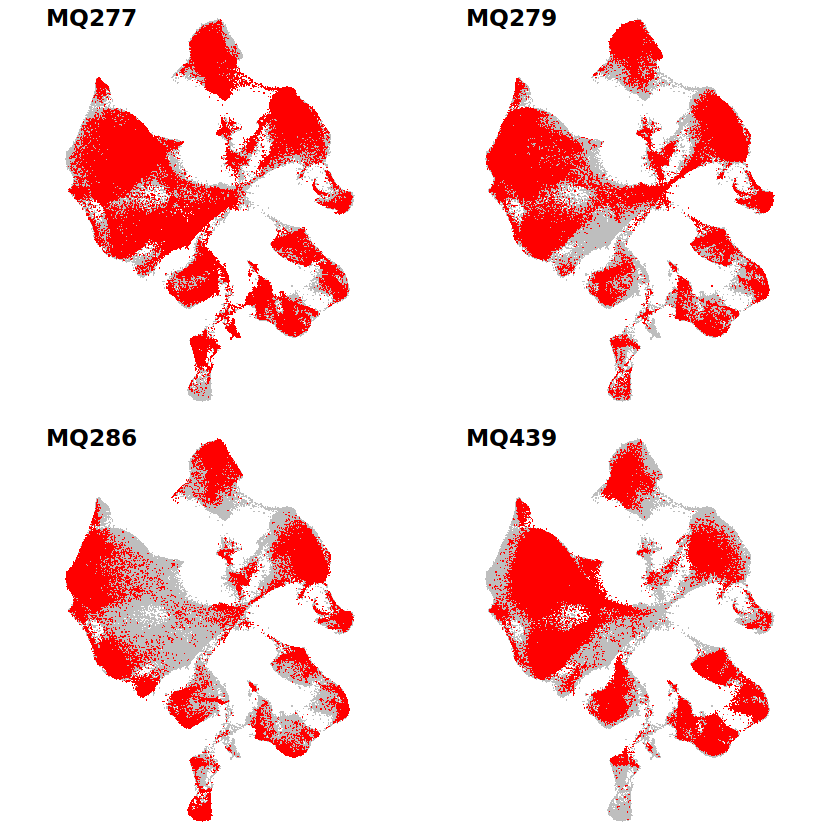

In [6]:
options(repr.plot.width=7, repr.plot.height=7)
myHighlightDimPlot(seurat, highlightBy="donor2", showAllPoints=T, size=0.1)
                   


Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 14896200)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 14896200)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 14896200)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 14896200)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 14896200)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 14896200)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 14896200)”
Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.SCT.harmony; see ?make.names for more details on syntax validity”
Computing nearest neighbor graph

Computing SNN

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via ret

An object of class Seurat 
43267 features across 297924 samples within 2 assays 
Active assay: SCT (21304 features, 5000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

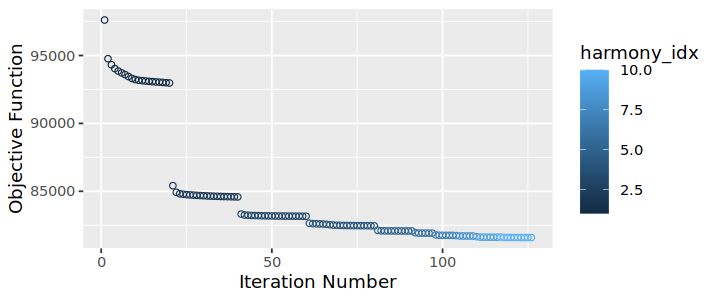

In [7]:
classFiltSeurat=seurat
# Run harmony
DefaultAssay(classFiltSeurat) = "SCT"
options(repr.plot.width=6, repr.plot.height=2.5)
classFiltSeurat = RunHarmony(
classFiltSeurat, group.by.vars="donor2", plot_convergence=T,
assay.use="SCT", reduction = "pca", dims.use=1:50
)
classFiltSeurat = classFiltSeurat %>%
FindNeighbors(reduction="harmony", dims = 1:50) %>%
FindClusters(verbose = FALSE) %>%
RunUMAP(reduction="harmony", dims = 1:50)
return(classFiltSeurat)


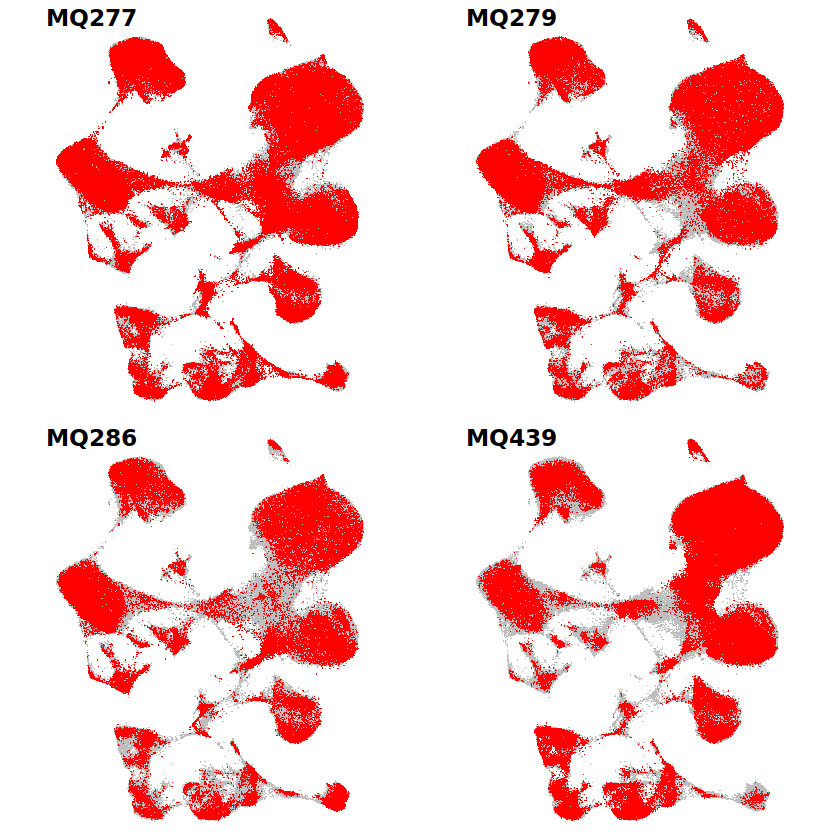

In [8]:
options(repr.plot.width=7, repr.plot.height=7)
myHighlightDimPlot(classFiltSeurat, highlightBy="donor2", showAllPoints=T, size=0.1)
                   

Warning message in FetchData.Seurat(object = object, vars = features, cells = cells):
“The following requested variables were not found (10 out of 13 shown): DLX6-AS1, AQP4, GJA1, DNAH12, ZMYDN10, IQCG, ALPHA-SMA, PDGFRALPHA, VECAD, CD105”
Warning message in FetchData.Seurat(object = object, vars = features, cells = cells):
“The following requested variables were not found (10 out of 13 shown): DLX6-AS1, AQP4, GJA1, DNAH12, ZMYDN10, IQCG, ALPHA-SMA, PDGFRALPHA, VECAD, CD105”


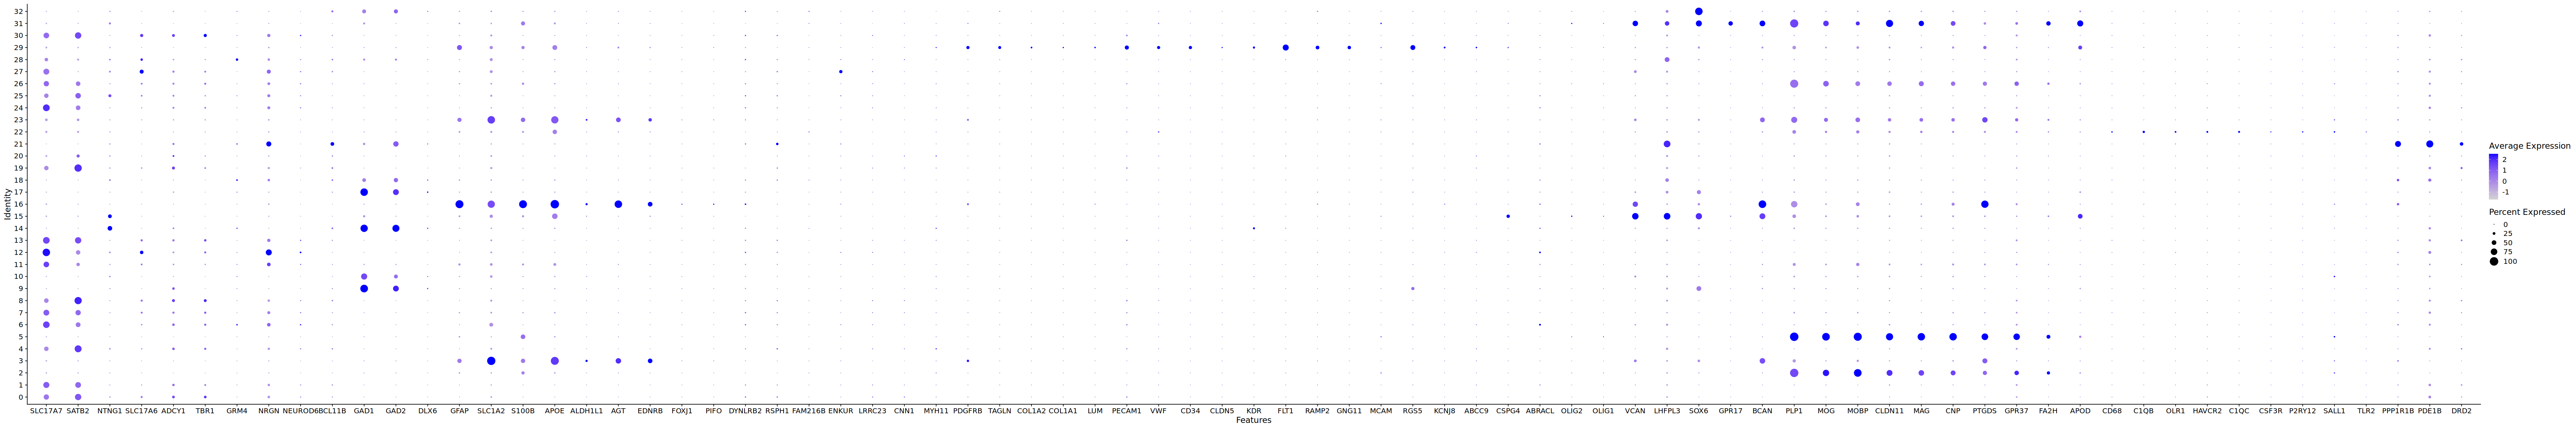

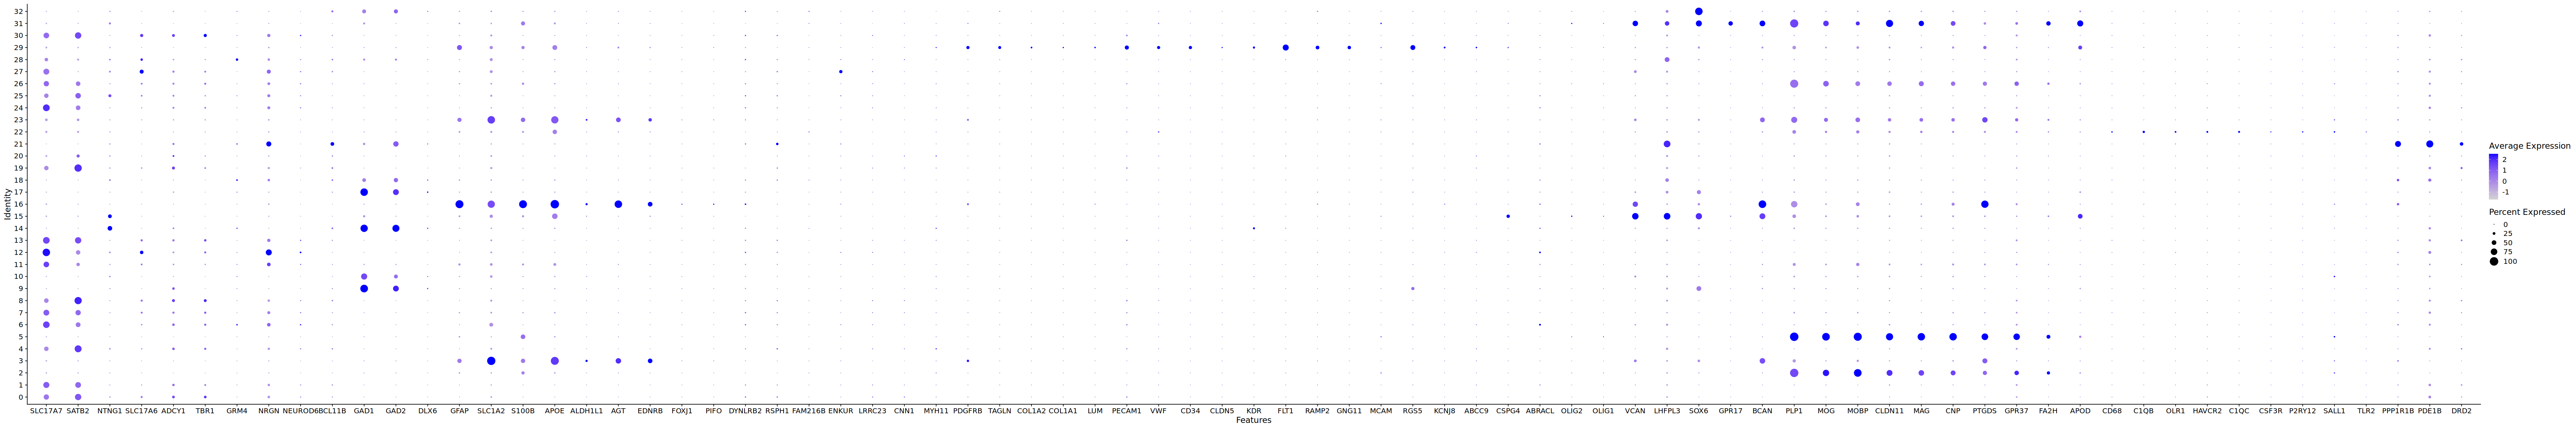

In [14]:
selectMarkers = c(
    "SLC17A7","SATB2",'NTNG1','SLC17A6','ADCY1','TBR1','GRM4','NRGN','NEUROD6','BCL11B', # Excit
    "GAD1", "GAD2",'DLX6','DLX6-AS1', # Inhib,
    "GFAP", "SLC1A2", "SLC1A2", "S100B", "AQP4", "APOE",'GJA1','ALDH1L1','AGT','EDNRB', # Astrocytes
    "FOXJ1", "PIFO", "DYNLRB2", "RSPH1", "DNAH12", "FAM216B", "ZMYDN10", "IQCG", "ENKUR","LRRC23", # Ependymal
    "CNN1", "MYH11", "PDGFRB", "TAGLN", "ALPHA-SMA", # VSMC
    "COL1A2", 'COL1A1','LUM','PDGFRALPHA',# VLMC
    "PECAM1","VWF","CD34","VECAD" ,"CLDN5","KDR","CD105",'FLT1','RAMP2','GNG11',# Endotheial
    "PDGFRB", "MCAM", "RGS5", "ALPHA-SMA", "KCNJ8",'TAGLN','COX4l2','MOTCH3','ABCC9','CSPG4', # Pericytes
    "ABRACL", "PDGFRALPHA", "OLIG2", "CSPG4", "OLIG1", "VCAN",'LHFPL3','SOX6','GPR17','BCAN', # OPC
    "PLP1",'MOG','MOBP','CLDN11','MAG','CNP','PTGDS','GPR37','FA2H','APOD', # Oligo
    'CD68','C1QB','OLR1','HAVCR2','C1QC','CSF3R','CS3CR1','P2RY12','SALL1','TLR2',# Microglia
    'PPP1R1B','BCL11B','PDE1B','DRD2'
)


selectMarkers=selectMarkers

selectMarkers=selectMarkers[!duplicated(selectMarkers)]
Idents(seurat) = "seurat_clusters"
options(repr.plot.height=10,repr.plot.width=60)
DotPlot(seurat, features = selectMarkers)




In [23]:
seurat@meta.data$class='Uncertain'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(0,1,4,6,7,8,12,13,19,24,25,27,30,20),]$class='Excit_Neuron'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(9,10,14,17),]$class='Inhibit_Neuron'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(3,16),]$class='Astrocytes'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(2,5),]$class='Oligo'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(29),]$class='Endotheial'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(18,21),]$class='MSN'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(15),]$class='OPC'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(22),]$class='Microglia'
#seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(),]$class='VLMC'



In [24]:
unique(seurat@meta.data[seurat@meta.data$class %in% 'Uncertain',]$seurat_clusters
)


[1] 11 28 23 32 31 26
33 Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ... 32

[1] 11 28 23 32 31 26
33 Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ... 32

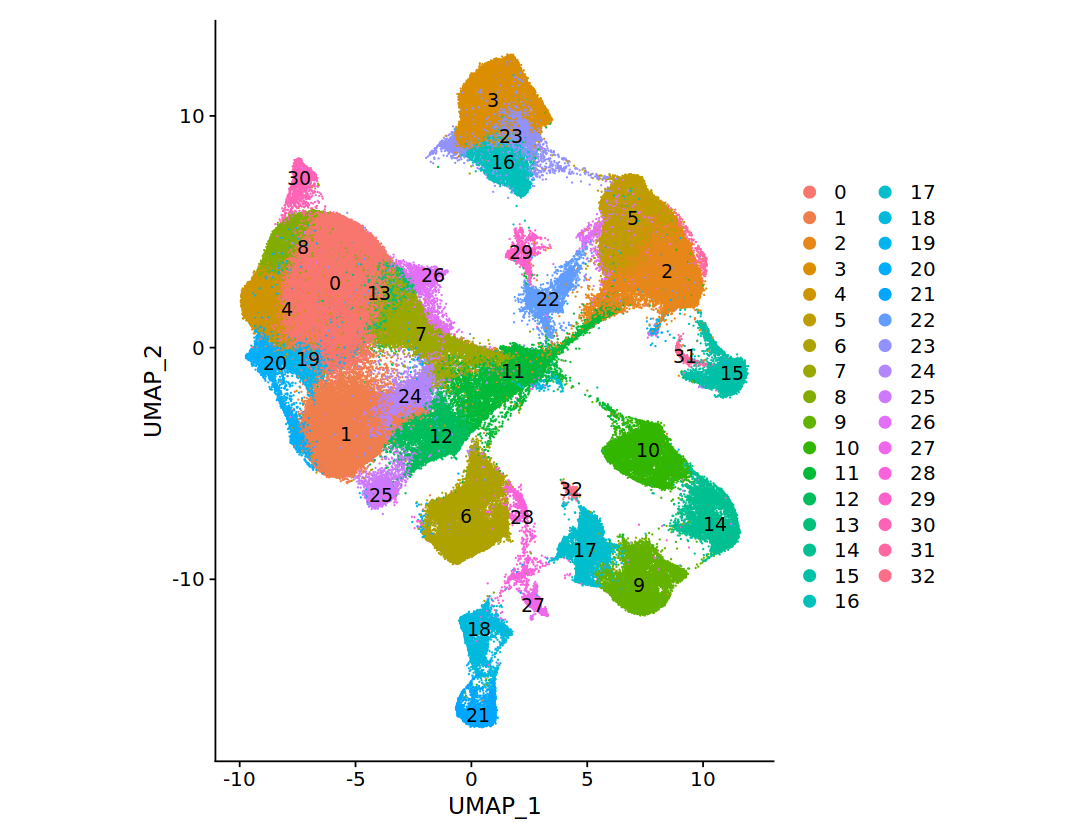

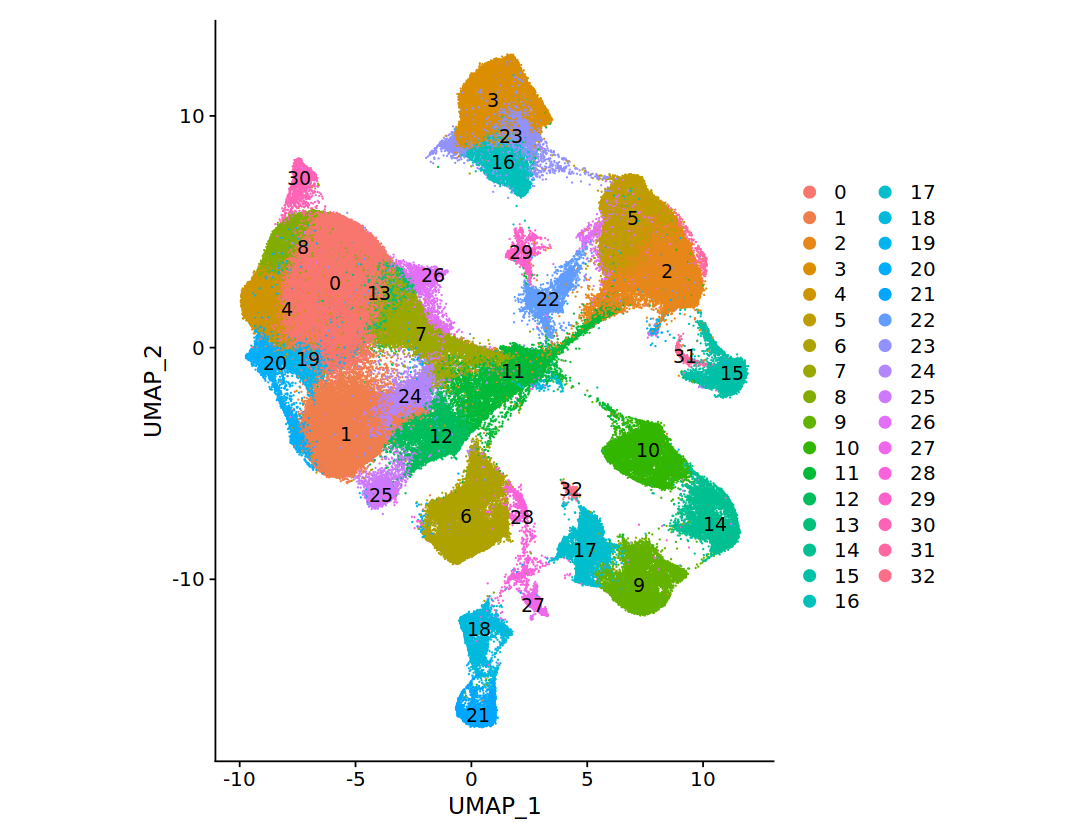

In [25]:
df_test=seurat@reductions$umap@cell.embeddings
df_test=as.data.frame(df_test)
df_test$X=rownames(df_test)

df_meta=seurat@meta.data
df_meta=as.data.frame(df_meta)
df_meta$X=rownames(df_meta)
df_meta=df_meta[,c('nFeature_RNA','X','seurat_clusters')]

df_test=left_join(df_test,df_meta,by='X')


Idents(seurat) = "seurat_clusters"
options(repr.plot.width=9, repr.plot.height=7)
DimPlot(seurat, reduction="umap", label=T,raster=FALSE)+coord_fixed()


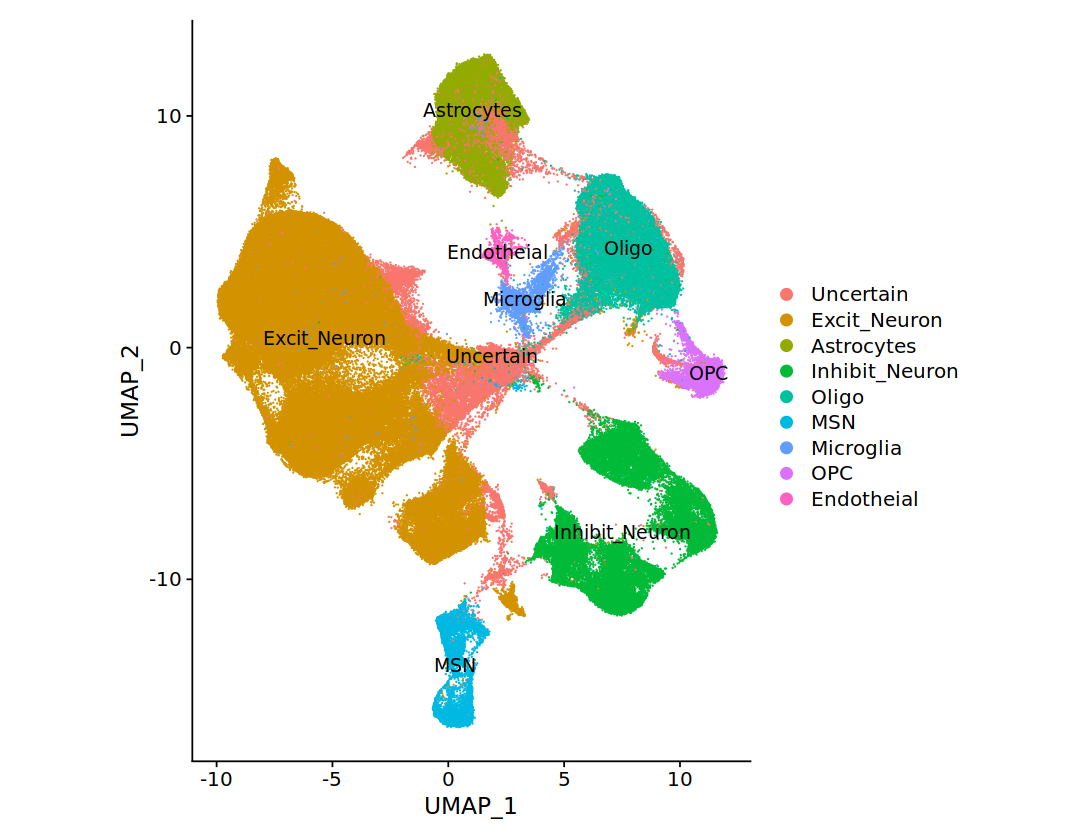

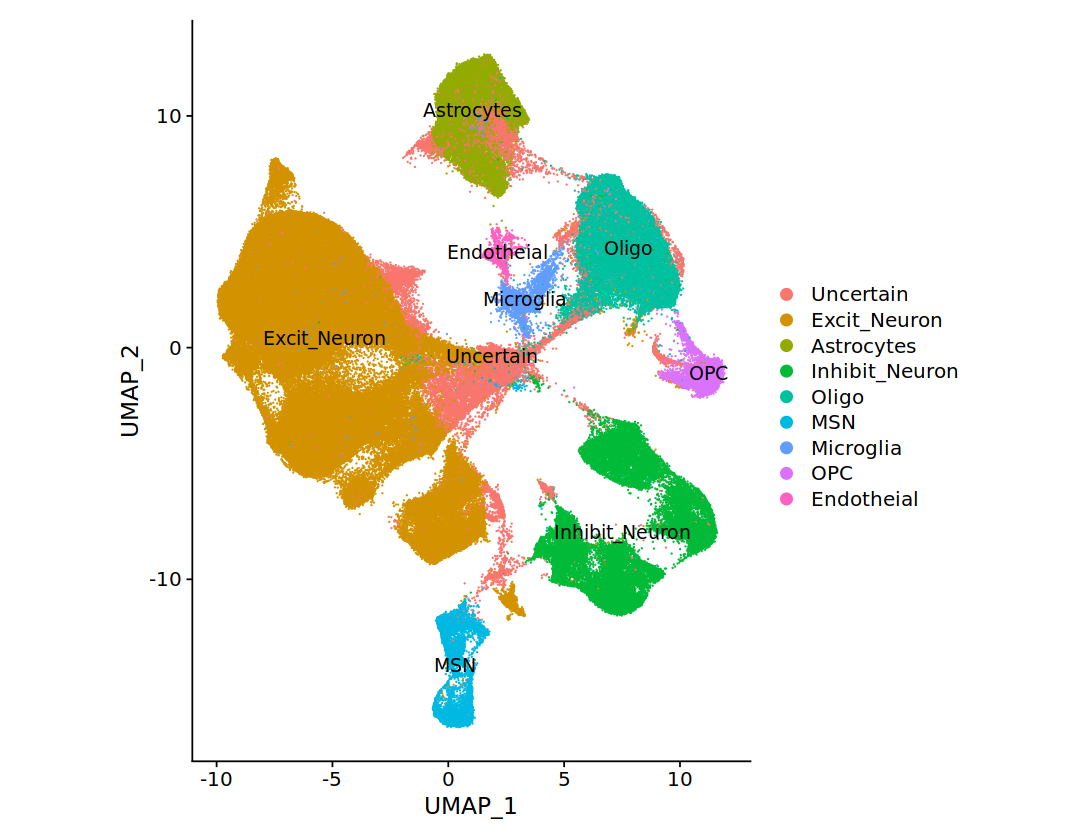

In [26]:
Idents(seurat) = "class"
options(repr.plot.width=9, repr.plot.height=7)
DimPlot(seurat, reduction="umap", label=T,raster=FALSE)+coord_fixed()

In [27]:
# 每个class抽样80%，最多500个细胞
sampleRatio = 0.8
maxCell = 5000
sampleDf = seurat@meta.data[, c("class"), drop=F]
sampleList = split(sampleDf, sampleDf$class)
sampleList = lapply(sampleList, function(x) {
    sampleSize = as.integer(nrow(x)*0.8)
    if (sampleSize > maxCell) {
        sampleSize = maxCell
    }
    sampleIdx = 1:nrow(x)
    sampleIdx = sample(1:nrow(x), size=sampleSize, replace=F)
    return(x[sampleIdx,,drop=F])
})
sampleDf = Reduce(rbind, sampleList)
str(sampleDf)
table(sampleDf$class)

trainSeurat = seurat[,rownames(sampleDf)]
table(trainSeurat$class)

'data.frame':	39815 obs. of  1 variable:
 $ class: chr  "Astrocytes" "Astrocytes" "Astrocytes" "Astrocytes" ...
'data.frame':	39815 obs. of  1 variable:
 $ class: chr  "Astrocytes" "Astrocytes" "Astrocytes" "Astrocytes" ...



    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
          5000           1373           5000           5000           3442 
           MSN          Oligo            OPC      Uncertain 
          5000           5000           5000           5000 


    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
          5000           1373           5000           5000           3442 
           MSN          Oligo            OPC      Uncertain 
          5000           5000           5000           5000 


    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
          5000           1373           5000           5000           3442 
           MSN          Oligo            OPC      Uncertain 
          5000           5000           5000           5000 


    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
          5000           1373           5000           5000           3442 
           MSN          Oligo            OPC      Uncertain 
          5000           5000           5000           5000 

In [28]:
Idents(trainSeurat) = "class"
classMarker = FindAllMarkers(trainSeurat)
#write_tsv(classMarker, paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.downsample5000ClassMarker.20220822.tsv"))


Calculating cluster Astrocytes

Calculating cluster Astrocytes

Calculating cluster Endotheial

Calculating cluster Endotheial

Calculating cluster Excit_Neuron

Calculating cluster Excit_Neuron

Calculating cluster Inhibit_Neuron

Calculating cluster Inhibit_Neuron

Calculating cluster Microglia

Calculating cluster Microglia

Calculating cluster MSN

Calculating cluster MSN

Calculating cluster Oligo

Calculating cluster Oligo

Calculating cluster OPC

Calculating cluster OPC

Calculating cluster Uncertain

Calculating cluster Uncertain




    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
            69             79             21             40             50 
           MSN          Oligo            OPC      Uncertain 
            83             85             35              7 


    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
            69             79             21             40             50 
           MSN          Oligo            OPC      Uncertain 
            83             85             35              7 

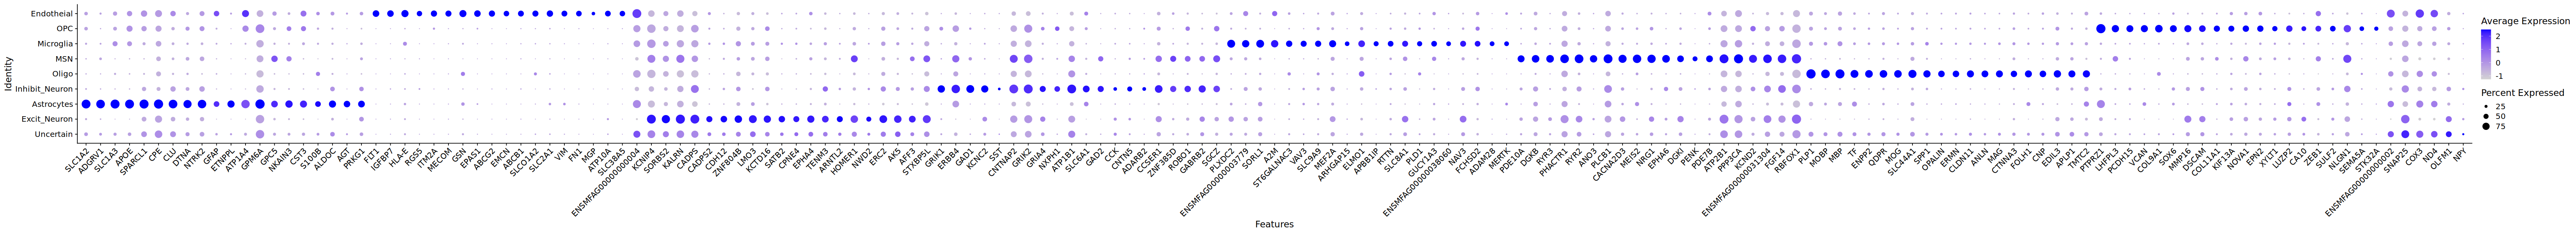

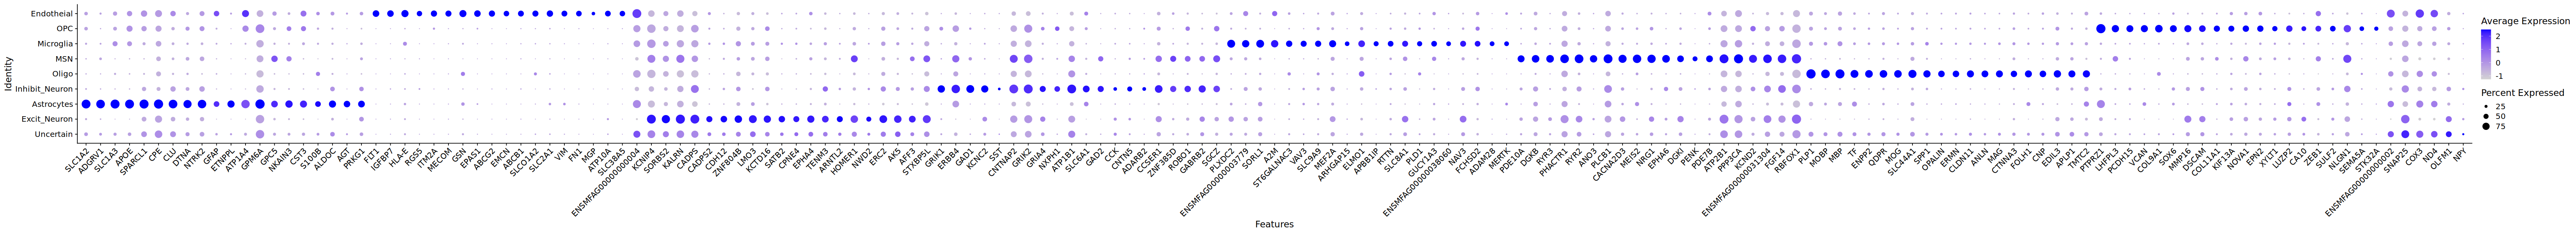

In [29]:
#classMarker = read_tsv(paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.downsample5000ClassMarker.20220822.tsv"))
classMarker = subset(classMarker, p_val_adj < 0.01 & avg_log2FC > 1)
table(classMarker$cluster)

classMarkerTop = classMarker %>% group_by(cluster) %>% top_n(n = 20, wt = avg_log2FC)
options(repr.plot.width=length(unique(classMarkerTop$gene))/3, repr.plot.height=5)
Idents(seurat) = "class"
DotPlot(seurat, features=unique(c(classMarkerTop$gene))) + RotatedAxis()

In [5]:
randomForest

function (x, ...) 
UseMethod("randomForest")
<bytecode: 0x55a52eba4af0>
<environment: namespace:randomForest>

In [30]:
trainDf = as.data.frame(t(as.matrix(trainSeurat[["SCT"]]@data[unique(classMarker$gene), ])))
trainDf$class = trainSeurat$class
trainDf = subset(trainDf, class != "Uncertain")
trainDf$class = factor(trainDf$class)
# We need to modify the name of the columns
colnames(trainDf) = paste0("col_", colnames(trainDf))
colnames(trainDf) = gsub("-", "_", colnames(trainDf))

rf = randomForest(col_class~., data=trainDf, ntree=500)
#saveRDS(rf, paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.class.randomForest.20220822.rds"))

 num [1:8, 1:9] 4974 44 7 15 66 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:8] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...
  ..$ : chr [1:9] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...


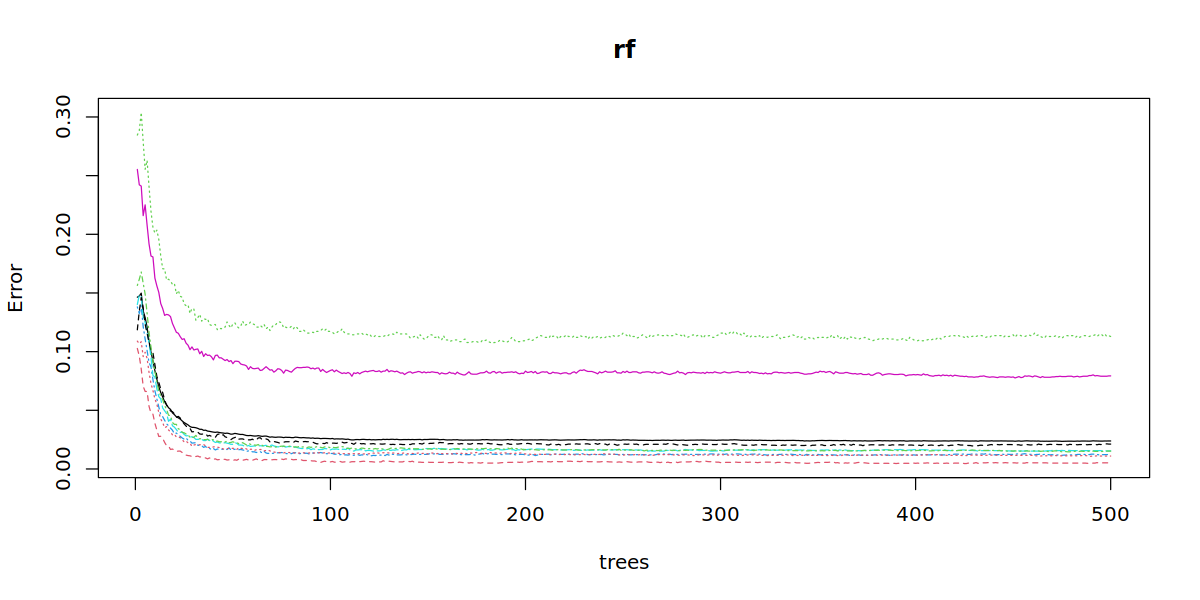

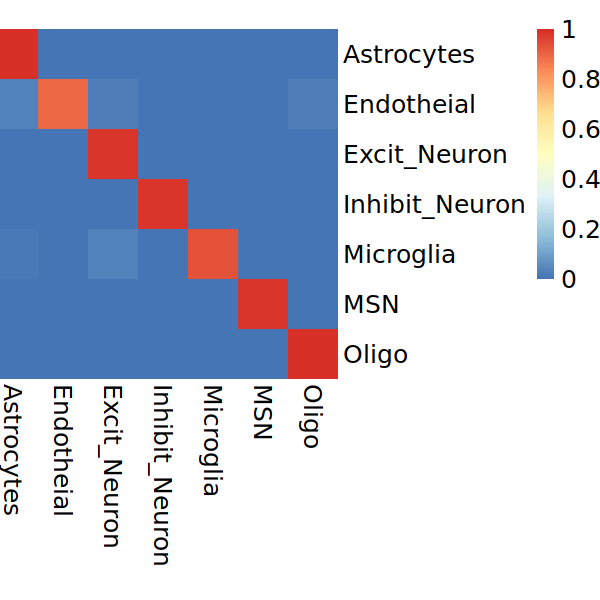

In [31]:
#rf = readRDS(paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.class.randomForest.20220822.rds"))
str(rf$confusion)
options(repr.plot.width=10, repr.plot.height=5)
plot(rf)

confusionRatio = t(apply(rf$confusion[1:7, 1:7], 1, function(x) {x/sum(x)}))
options(repr.plot.width=5, repr.plot.height=5)
pheatmap(confusionRatio, breaks=seq(0,1,0.01), cluster_rows=F, cluster_cols=F, border_color=NA, cellwidth=30, cellheight=30, fontsize=15)

 'matrix' num [1:297924, 1:8] 0.004 0.002 0.528 0 0.024 0.008 0.036 0.004 0.002 0.01 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:297924] "6103-1_CELL148_N3" "6103-1_CELL538_N2" "6103-1_CELL6244_N1" "6103-1_CELL559_N2" ...
  ..$ : chr [1:8] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...


cellId,maxPredClassScore,maxPredClass
<chr>,<dbl>,<chr>
6103-1_CELL148_N3,0.696,Excit_Neuron
6103-1_CELL538_N2,0.860,Excit_Neuron
6103-1_CELL6244_N1,0.528,Astrocytes
6103-1_CELL559_N2,0.828,Inhibit_Neuron
6103-1_CELL6281_N1,0.554,Oligo
6103-1_CELL2198_N1,0.912,Excit_Neuron


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.156   0.800   0.918   0.856   0.970   1.000 

[1] TRUE

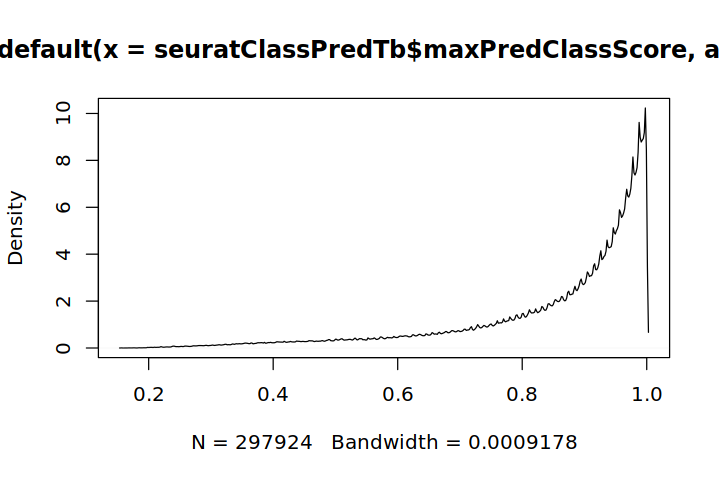

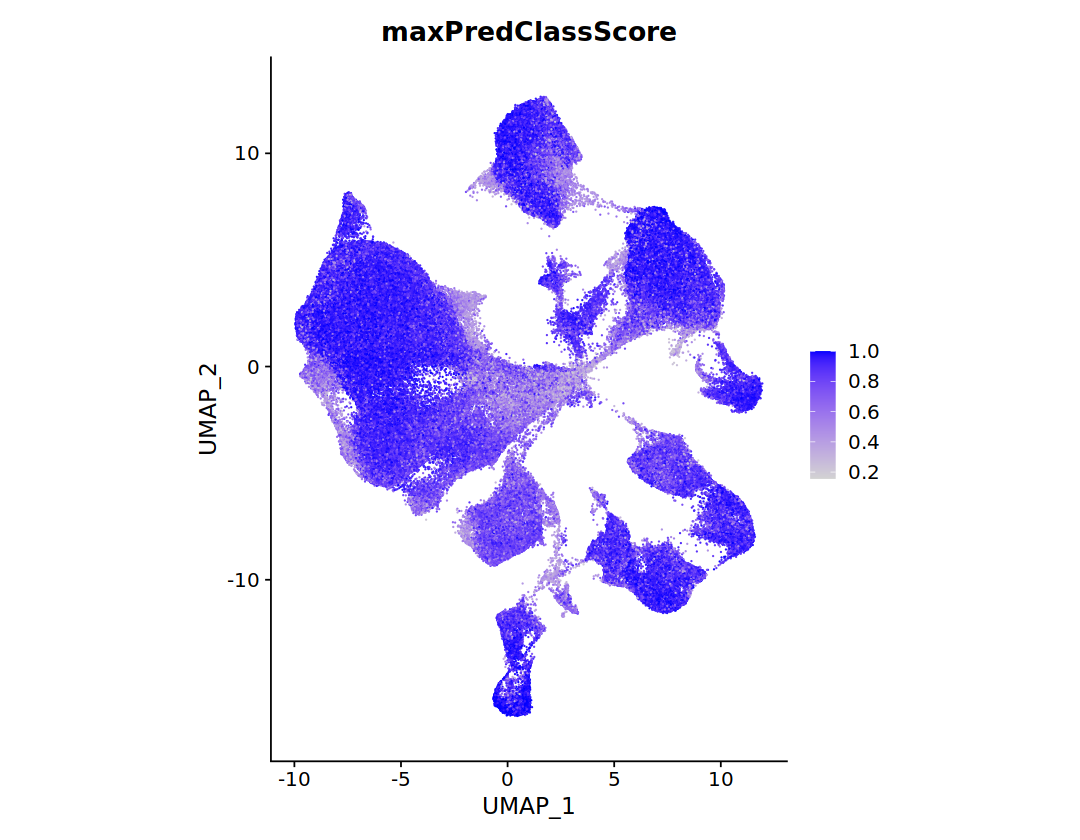

In [32]:
# Apply the trainer to filter cells
seuratCountDf = as.data.frame(t(as.matrix(seurat[["SCT"]]@data[unique(classMarker$gene), ])))
colnames(seuratCountDf) = paste0("col_", colnames(seuratCountDf))
colnames(seuratCountDf) = gsub("-", "_", colnames(seuratCountDf))
seuratClassPred = predict(rf, seuratCountDf, type="prob")
str(seuratClassPred)

seuratClassPredTb = tibble(
    cellId = rownames(seuratClassPred),
    maxPredClassScore = apply(seuratClassPred, 1, max),
    maxPredClass = apply(seuratClassPred, 1, function(x) {names(x)[which.max(x)]})
)
head(seuratClassPredTb)

summary(seuratClassPredTb$maxPredClassScore)
options(repr.plot.width=6, repr.plot.height=4)
plot(density(seuratClassPredTb$maxPredClassScore, adjust=0.1))

identical(seuratClassPredTb$cellId, rownames(seurat@meta.data))
tmpDf = as.data.frame(seuratClassPredTb[c("maxPredClassScore", "maxPredClass")])
rownames(tmpDf) = seuratClassPredTb$cellId

seurat = AddMetaData(seurat, tmpDf)

options(repr.plot.width=9, repr.plot.height=7)
FeaturePlot(seurat, reduction="umap", features="maxPredClassScore",raster=FALSE)+coord_fixed()


In [33]:
# Filter class outliers
# Removed clusters classified with ambiguous labels
# Removed cells classified with a different label from the majority of cells in its clusters
# Removed outliers when clustering, typically on the fringes of clusters in U-map space

Idents(seurat) = "seurat_clusters"
cellNum0 = ncol(seurat)
classFiltSeurat = subset(seurat, maxPredClassScore >= 0.75)
cellNum1 = ncol(classFiltSeurat)
message("Filt cell ratio: ", cellNum1/cellNum0)



Filt cell ratio: 0.808008082598247



In [34]:
seurat
classFiltSeurat

An object of class Seurat 
43267 features across 297924 samples within 2 assays 
Active assay: SCT (21304 features, 5000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
43267 features across 240725 samples within 2 assays 
Active assay: SCT (21304 features, 5000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [35]:
#EXIN按照nfeature800过滤
df_fil=classFiltSeurat@meta.data
EX_cell=rownames(df_fil[df_fil$nFeature_RNA > 800 & df_fil$maxPredClass=='Excit_Neuron',])
IN_cell=rownames(df_fil[df_fil$nFeature_RNA > 800 & df_fil$maxPredClass=='Inhibit_Neuron',])
Other_cell=rownames(df_fil[df_fil$maxPredClass %in% setdiff(unique(df_fil$maxPredClass),c('Excit_Neuron','Inhibit_Neuron')),])
fil_cell=c(EX_cell,IN_cell,Other_cell)

classFiltSeurat=subset(classFiltSeurat,cells = fil_cell)

classFiltSeurat


An object of class Seurat 
43267 features across 237212 samples within 2 assays 
Active assay: SCT (21304 features, 5000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [36]:
saveRDS(classFiltSeurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0821_renew_batch3_all/batch_normalize_renew_0105/macaque_snrna_batch123_soupX_fil300_800_SCT_0106_SCT.rds')




In [ ]:
classFiltSeurat=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0821_renew_batch3_all/batch_normalize_renew_0105/macaque_snrna_batch123_soupX_fil300_800_SCT_0106_SCT.rds')


